[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/additive_coag_comparison.ipynb)

In [1]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [11]:
# pylint: disable=too-few-public-methods, import-outside-toplevel, missing-class-docstring


This notebook aims to compare the results of three stochastic particle-based models using a coagulation only box model test case.
The models (PyPartMC, PySDM, and Droplets.jl) model the evolution of the droplet size distribution using the Golovin (additive) collision kernel [Golovin 1963](http://mi.mathnet.ru/dan27630).
These settings reproduce Figure 2 in section 5.1.4 of [Shima et al. 2009](https://DOI.org/10.1002/qj.441) as a "Hello World" for droplet collisional growth.
[PySDM](https://open-atmos.github.io/PySDM/) and [Droplets.jl](https://github.com/emmacware/droplets.jl) use the Shima et al. 2009 coagulation scheme (Super-Droplet Method or SDM), and PyPartMC uses the Weighted Flow Algorithm (WFA) for droplet coagulation [DeVille et al. 2011](https://DOI.org/10.1016/j.jcp.2011.07.027) 

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')

In [20]:
import platform 
from collections import namedtuple
from functools import partial
import urllib
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils.show_anim import show_anim 

In [21]:
SETTINGS = {
    'N_PART': 2**16,
    'VOLUME_M3': 1e6,
    'DT_SEC': 1.,
    
    # Plotting parameters
    'N_BINS': 128,
    'R_BINS_MIN': 1e-5,
    'R_BINS_MAX': 5e-3,
    'NUM_CONC_PER_M3': 2**23,
    'DIAM_AT_MEAN_VOL_M': 2*30.531e-6,
    'ADDITIVE_KERNEL_COEFF': 1500,
    'T_MAX_SEC': 3600,
    'PLOT_TIME_STEP': 120 # seconds
}
SETTINGS['N_BIN_EDGES'] = SETTINGS["N_BINS"] + 1

with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETTINGS, f)

SETTINGS = namedtuple("Settings", SETTINGS.keys())(**SETTINGS)  # ensure immutable

class Run:
    def __init__(self, settings):
        print(f"Running {self.__class__.__name__}")
        self.settings = settings

In [53]:
class AnalyticalSoln(Run):
    """
    Analytical solution for the Golovin kernel taken from PySDM 
    """
    def __init__(self, settings):
        super().__init__(settings)

        from PySDM import Formulae
        from PySDM.dynamics.collisions import collision_kernels 

        self.formulae = Formulae()
        radius_bins_edges = np.logspace(
            np.log10(settings.R_BINS_MIN),
            np.log10(settings.R_BINS_MAX),
            num=settings.N_BIN_EDGES,
            endpoint=True
        )
        volume_bins_edges = self.formulae.trivia.volume(radius_bins_edges)
        dv, dr = np.diff(volume_bins_edges), np.diff(radius_bins_edges)
        self.dv_over_dr = dv / dr
        pdf_v_x = volume_bins_edges[:-1] + dv / 2
        self.pdf_r_x = radius_bins_edges[:-1] + dr / 2
        
        self.collision_kernel=collision_kernels.Golovin(b=settings.ADDITIVE_KERNEL_COEFF)
        self.times = np.linspace(
            start=0, stop=settings.T_MAX_SEC,
            num=int(settings.T_MAX_SEC // settings.PLOT_TIME_STEP)+1
        )
        self.analytical_solution = partial(
            self.collision_kernel.analytic_solution,
            x = pdf_v_x,
            x_0= self.formulae.trivia.volume(settings.DIAM_AT_MEAN_VOL_M / 2),
            N_0=self.settings.NUM_CONC_PER_M3
        )

    def __call__(self):  
        from PySDM.physics import si

        out = {'Number Concentration (m^-3)':{}, 'Mass Density (g/m^3 dlnr)':{}}

        for step in range(int(self.settings.T_MAX_SEC // self.settings.PLOT_TIME_STEP)+1):
            t = step*self.settings.PLOT_TIME_STEP or 1e-10 #For 0 time

            pdf_v_y = (
                self.settings.NUM_CONC_PER_M3
                * self.settings.VOLUME_M3
                * self.analytical_solution(t=t)
            )
            pdf_r_y = pdf_v_y * self.dv_over_dr * self.pdf_r_x
            y_true_mass_density = (
                pdf_r_y
                * self.formulae.trivia.volume(radius=self.pdf_r_x)
                * self.formulae.constants.rho_w
                / self.settings.VOLUME_M3*si.metres**3
                * si.kilograms
                / si.grams
            )
            y_true_number_density = (
                pdf_r_y
                / self.settings.VOLUME_M3*si.metres**3
            )
            out['Mass Density (g/m^3 dlnr)'][step] = y_true_mass_density
            out['Number Concentration (m^-3)'][step] = y_true_number_density

        return out

In [54]:
class RunPySDM(Run):
    def __init__(self, settings):
        import PySDM
        from PySDM.physics import si

        builder = PySDM.Builder(
            settings.N_PART,
            backend=PySDM.backends.CPU(),
            environment=PySDM.environments.Box(
                dt=settings.DT_SEC * si.s,
                dv=settings.VOLUME_M3 * si.m**3
            )
        )
        trivia = builder.formulae.trivia
        spectrum = PySDM.initialisation.spectra.Exponential(
            norm_factor=settings.NUM_CONC_PER_M3 * settings.VOLUME_M3 / si.m**3,
            scale=trivia.volume(radius=settings.DIAM_AT_MEAN_VOL_M / 2 * si.m)
        )
        builder.add_dynamic(PySDM.dynamics.Coalescence(
            collision_kernel=PySDM.dynamics.collisions.collision_kernels.Golovin(
                b=settings.ADDITIVE_KERNEL_COEFF
            ), adaptive=False
        ))

        self.radius_bins_edges=np.logspace(
            np.log10(settings.R_BINS_MIN),
            np.log10(settings.R_BINS_MAX),
            num=settings.N_BIN_EDGES,
            endpoint=True
        )

        self.particulator = builder.build(
            attributes=builder.particulator.environment.init_attributes(
                spectral_discretisation=PySDM.initialisation.sampling.spectral_sampling.Logarithmic(
                    spectrum,
                )
            ),
            products=(
                PySDM.products.ParticleSizeSpectrumPerVolume(
                    radius_bins_edges=self.radius_bins_edges,
                    name='Number Concentration (m^-3)',
                ),
                PySDM.products.ParticleVolumeVersusRadiusLogarithmSpectrum(
                    radius_bins_edges=self.radius_bins_edges,
                    name='Mass Density (g/m^3 dlnr)',
                )
            )
        )
        super().__init__(settings)

    def __call__(self):
        from PySDM.physics import si, constants_defaults

        pysdm_output = {'Number Concentration (m^-3)':{}, 'Mass Density (g/m^3 dlnr)':{}}
        for step in range(int(self.settings.T_MAX_SEC // self.settings.PLOT_TIME_STEP)+1):
            if step != 0:
                self.particulator.run(int(self.settings.PLOT_TIME_STEP // self.settings.DT_SEC))
            #next two lines convert from dr to dlnr
            pysdm_output['Number Concentration (m^-3)'][step] = (
                self.particulator.products['Number Concentration (m^-3)'].get() 
                * (self.radius_bins_edges[1:]-self.radius_bins_edges[:-1])
                / (np.log(self.radius_bins_edges[1:]) - np.log(self.radius_bins_edges[:-1]))
            )
            pysdm_output['Mass Density (g/m^3 dlnr)'][step] = (
                self.particulator.products['Mass Density (g/m^3 dlnr)'].get()[0]
                * constants_defaults.rho_w * si.kilogram / si.metre**3 / si.g
            )
        return pysdm_output

In [55]:
class RunPartMC(Run):
    def __init__(self, settings):
        import PyPartMC as ppmc
        gas_data = ppmc.GasData(("Background","NO2"))
        env_state = ppmc.EnvState(
            {
                "rel_humidity": .99,
                "latitude": 40,
                "longitude": 0,
                "altitude": 0 * ppmc.si.m,
                "start_time": 0 * ppmc.si.s,
                "start_day": 1,
            }
        )
        env_state.additive_kernel_coefficient = settings.ADDITIVE_KERNEL_COEFF
        assert env_state.additive_kernel_coefficient == settings.ADDITIVE_KERNEL_COEFF

        aero_data = ppmc.AeroData((
            {"H2O": [1000 * ppmc.si.kg / ppmc.si.m**3, 0, 18.0 * ppmc.si.g / ppmc.si.mol, 0.00]},
        ))
        self.gas_state = ppmc.GasState(gas_data)
        placeholder_gas = [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]},
            {"dist": [[{"placeholder": {
                "mass_frac": [{"H2O": [1]}],
                "diam_type": "geometric",
                "mode_type": "log_normal",
                "num_conc": 0 / ppmc.si.m**3,
                "geom_mean_diam": 0.02 * ppmc.si.um,
                "log10_geom_std_dev": 0.161,
            },}]]},
        ]

        scenario = ppmc.Scenario(
            gas_data,
            aero_data,
            {
                "temp_profile": [{"time": [0]}, {"temp": [300]}],
                "pressure_profile": [
                    {"time": [0]},
                    {"pressure": [100000]},
                ],
                "height_profile": [{"time": [0]}, {"height": [1000]}],
                "gas_emissions": placeholder_gas,
                "gas_background": placeholder_gas,
                "aero_emissions": placeholder_gas,
                "aero_background":placeholder_gas,
                "loss_function": "none",
            },
        )

        scenario.init_env_state(env_state, 0.0)
        aero_dist_init = ppmc.AeroDist(aero_data, [
            {
                "init1": {
                    "mass_frac": [{"H2O": [1]}],
                    "diam_type": "geometric",
                    "mode_type": "exp",
                    "num_conc": settings.NUM_CONC_PER_M3 / ppmc.si.m**3,
                    "diam_at_mean_vol": settings.DIAM_AT_MEAN_VOL_M * ppmc.si.m,
                },
            }
        ])

        run_part_opt = ppmc.RunPartOpt(
            {
                "output_prefix": 'additive',
                "do_coagulation": True,
                "coag_kernel": "additive",
                "t_max": settings.T_MAX_SEC * ppmc.si.s,
                "del_t": settings.DT_SEC * ppmc.si.s,
            }
        )

        self.aero_state = ppmc.AeroState(aero_data, settings.N_PART, "flat")
        self.aero_state.dist_sample(aero_dist_init)

        self.run_part_args = (
            scenario,
            env_state,
            aero_data,
            self.aero_state,
            gas_data,
            self.gas_state,
            run_part_opt,
            ppmc.CampCore(),
            ppmc.Photolysis(),
        )
        self.rad_grid = ppmc.BinGrid(
            settings.N_BINS, "log", settings.R_BINS_MIN, settings.R_BINS_MAX
        )
        super().__init__(settings)
            
    def __call__(self):
        import PyPartMC as ppmc

        N_STEPS = int(self.settings.T_MAX_SEC / self.settings.DT_SEC)

        dists = []
        diameters = self.aero_state.diameters()
        num_concs = self.aero_state.num_concs
        masses = self.aero_state.masses()
        mass_concs = np.array(num_concs) * np.array(masses)
        dists_mass = []
        dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
        dists_mass.append(
            ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g)
        )

        last_output_time = 0.
        last_progress_time = 0.
        i_output = 1
        t_initial = 0
        for i_time in range(1,N_STEPS + 1):
            (last_output_time, last_progress_time, i_output) = ppmc.run_part_timestep(
                *self.run_part_args,
                i_time,
                t_initial,
                last_output_time,
                last_progress_time,
                i_output
            )
            
            if np.mod(i_time * self.settings.DT_SEC, self.settings.PLOT_TIME_STEP) == 0:
                diameters = self.aero_state.diameters()
                num_concs = self.aero_state.num_concs
                masses = self.aero_state.masses()
                mass_concs = np.array(num_concs) * np.array(masses)
                dists.append(ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, num_concs))
                dists_mass.append(
                    ppmc.histogram_1d(self.rad_grid, np.array(diameters)/2, mass_concs / ppmc.si.g)
                )

        return {'Number Concentration (m^-3)': dists, 'Mass Density (g/m^3 dlnr)': dists_mass}

In [56]:
class RunDropletsJL(Run):
    def __init__(self, _):
        BASE_URL = (
            # replace main with commit id for previous commit
            'https://raw.githubusercontent.com/emmacware/Droplets.jl/refs/heads/main/' 
        )
        for path in (
            'Examples/testfunctions.jl', 'Examples/DSDvis.jl','src/SDfunc/coalescence.jl'
        ):
            with open('Droplets.jl-' + path.replace('/','-'), 'w', encoding='utf-8') as fout:
                with urllib.request.urlopen(BASE_URL + path) as fin:
                    fout.write(fin.read().decode('utf-8'))
                    
        code_to_write = """
        using Pkg
        Pkg.add(["Combinatorics", "Distributions", "Random", "JSON", "DelimitedFiles", "CPUTime", "Plots"])
        using Random,Combinatorics,Distributions,CPUTime
        include("Droplets.jl-src-SDfunc-coalescence.jl")
        include("Droplets.jl-Examples-DSDvis.jl")
        include("Droplets.jl-Examples-testfunctions.jl")
        using DelimitedFiles,JSON,Plots
            
        FT = Float64
        setup = JSON.parsefile("./setup.json")

        Ns::Int = setup["N_PART"]
        FT = Float64
        num_bins::Int = setup["N_BINS"]
        radius_bins_edges = 10 .^ range(log10(setup["R_BINS_MIN"]), log10(setup["R_BINS_MAX"]), length=setup["N_BIN_EDGES"]) 
        R0 = FT(setup["DIAM_AT_MEAN_VOL_M"])/2
        T_MAX_SEC = setup["T_MAX_SEC"]
        PLOT_TIME_STEP = setup["PLOT_TIME_STEP"]
        output_steps = collect(0:PLOT_TIME_STEP:T_MAX_SEC)

        
        coagsettings = coag_settings{FT}(Ns=Ns,Δt=setup["DT_SEC"],ΔV=setup["VOLUME_M3"],
                golovin_kernel_coeff=FT(setup["ADDITIVE_KERNEL_COEFF"]), n0=FT(setup["NUM_CONC_PER_M3"]),R0=R0)
        runsettings_numberdens =run_settings{FT}(num_bins=num_bins,radius_bins_edges=radius_bins_edges,
                smooth = false,output_steps=output_steps,init_method=init_logarithmic,binning_method = number_density)
        runsettings_mass_density =run_settings{FT}(num_bins=num_bins,radius_bins_edges=radius_bins_edges,
                smooth = false,output_steps=output_steps,init_method=init_logarithmic,binning_method = mass_density_lnr)

        drops = runsettings_numberdens.init_method(coagsettings)
        num_dens_bin,timing = coag_runtime(1,drops,coagsettings,runsettings_numberdens)

        drops = runsettings_mass_density.init_method(coagsettings)
        mass_dens_bin,timing = coag_runtime(2,drops,coagsettings,runsettings_mass_density)

        dict = Dict()
        dict["Number Concentration (m^-3)"] = num_dens_bin
        dict["Mass Density (g/m^3 dlnr)"] = mass_dens_bin
        json_string = JSON.json(dict)

        open("output.json", "w") do file
            write(file, json_string)
        end
        """

        with open('script.jl', 'w', encoding='utf-8') as file:
            file.write(code_to_write)

        super().__init__(SETTINGS)
    
    def __call__(self):
        subprocess.run(["julia", "script.jl"], check=True)
        with open('output.json', 'r', encoding='utf8') as file:
            Droplets = json.load(file)
        return Droplets

In [57]:
models = {
    'analytical': AnalyticalSoln(SETTINGS),
    'partmc': RunPartMC(SETTINGS),
    'pysdm': RunPySDM(SETTINGS),
}
if platform.system() != 'Windows':
    models['droplets'] = RunDropletsJL(SETTINGS)
output = {k:model() for k, model in models.items()}

Running AnalyticalSoln
Running RunPartMC
Running RunPySDM


/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


Running RunDropletsJL


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


Running simulation...
simtime =3.238209
coal_func_time =2.991538999999999
Running simulation...
simtime =3.002745
coal_func_time =2.8181570000000002



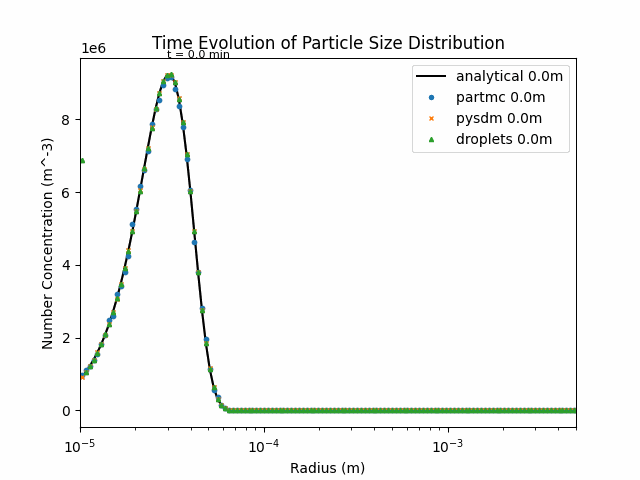

HTML(value="<a href='./tmpvshjfu_1.gif' target='_blank'>./tmpvshjfu_1.gif</a><br>")


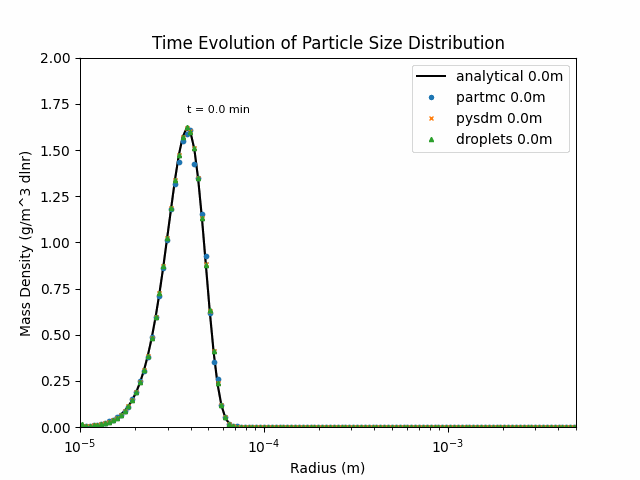

HTML(value="<a href='./tmpdz4l_hc8.gif' target='_blank'>./tmpdz4l_hc8.gif</a><br>")

In [58]:
t_steps = np.divide(
    np.array(range(0, int(SETTINGS.T_MAX_SEC+1), 1200)),
    SETTINGS.PLOT_TIME_STEP
).astype(int)
radius_bins = np.array(models['partmc'].rad_grid.centers)

markers = {
    'partmc':'o', 
    'pysdm':'x',
    'droplets':'^',
}   

class AnimFunc:
    def __init__(self, binning_method):
        self.binning_method = binning_method

    def __call__(self, frame):
        if frame > SETTINGS.T_MAX_SEC/SETTINGS.PLOT_TIME_STEP:
            frame = int(SETTINGS.T_MAX_SEC/SETTINGS.PLOT_TIME_STEP)

        t = list(range(0, int((frame+1)*SETTINGS.PLOT_TIME_STEP), 1200))

        def plot(step, color_analytic, color_monte_carlo, label=False):
            for key in models:
                xy = radius_bins, output[key][self.binning_method][step]
                label_arg = key + ' ' + str(step*SETTINGS.PLOT_TIME_STEP/60) + 'm' if label else ''
                if key == 'analytical':
                    plt.plot(*xy, color=color_analytic, label=label_arg)
                else:
                    plt.plot(*xy, markers[key], ms=3, color=color_monte_carlo, label=label_arg)

        for t_sec in t:
            step = int(t_sec/SETTINGS.PLOT_TIME_STEP)
            idx = np.argmax(output['analytical'][self.binning_method][step])
            text_height = 1.05*max(output['analytical'][self.binning_method][step])
            plt.text(radius_bins[idx], text_height, f't = {t_sec/60} min', fontsize=8)
            plot(step, 'darkgrey', 'darkgrey')
        plot(frame, 'black', None, label=True)
        
        plt.xscale("log")
        plt.xlabel("Radius (m)")
        plt.ylabel(self.binning_method)
        if self.binning_method != 'Number Concentration (m^-3)':
            plt.ylim([0,2])
        plt.xlim([SETTINGS.R_BINS_MIN,SETTINGS.R_BINS_MAX])
        plt.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))
        plt.title("Time Evolution of Particle Size Distribution")
        return plt.gcf()

for spectrum_type in output['analytical']:
    show_anim(
        plot_func=AnimFunc(spectrum_type),
        frame_range=range(0,int(SETTINGS.T_MAX_SEC/SETTINGS.PLOT_TIME_STEP)+20,1),
    )

In [59]:
# #TODO #392: add assert on match with analytical solution